# 1. LSTM (Long Short-Term Memory)

## Khái niệm
LSTM được phát triển để khắc phục hạn chế của RNN.  
LSTM có khả năng ghi nhớ thông tin lâu dài và loại bỏ thông tin không cần thiết nhờ cơ chế cổng (gates).

## Ý tưởng thuật toán
LSTM vẫn duy trì chuỗi trạng thái ẩn như RNN, nhưng có thêm:
- Cell state (bộ nhớ chính) – nơi lưu trữ thông tin lâu dài.
- Ba loại cổng (gates) điều khiển dòng chảy thông tin:
  - **Forget gate:** quyết định thông tin nào cần quên.  
  - **Input gate:** quyết định thông tin nào cần thêm vào bộ nhớ.  
  - **Output gate:** quyết định thông tin nào được xuất ra ngoài.


# 2. Quy trình chuẩn bị dữ liệu, huấn luyện và đánh giá LSTM

## 2.1 Mô tả bộ dữ liệu

### Nguồn dữ liệu:

- Dataset “Bike Sharing Dataset” được chia sẻ trên Kaggle (tác giả: marklvl).
- Dữ liệu ban đầu được thu thập bởi Hadi Fanaee-T (LIAAD Lab, University of Porto) từ hệ thống chia sẻ xe đạp công cộng tại Washington D.C., Hoa Kỳ (2011–2012).
- Bộ dữ liệu mô tả số lượng xe đạp được thuê theo thời gian, cùng với các yếu tố ảnh hưởng như thời tiết, mùa, ngày làm việc, ngày lễ.

### Mục tiêu bài toán:
- Xây dựng mô hình dự báo số lượng xe đạp được thuê (cột cnt) dựa trên các yếu tố thời tiết và thời gian.

→ Đây là bài toán hồi quy (Regression), trong đó biến mục tiêu là cnt – tổng số xe đạp được thuê (casual + registered).

### Quy mô dữ liệu:

- 2 tệp dữ liệu chính:

- hour.csv: 17.379 mẫu (mỗi mẫu là 1 giờ)

- day.csv: 731 mẫu (mỗi mẫu là 1 ngày)

- 16–17 cột dữ liệu.

- Không có giá trị thiếu (missing values).

- Dữ liệu đã được chuẩn hóa ở một số cột (ví dụ: temp, hum, windspeed).

### Các thuộc tính chính của hour.csv:
| Thuộc tính     | Mô tả                                     | Kiểu dữ liệu     |
| -------------- | ----------------------------------------- | ---------------- |
| **instant**    | Số thứ tự của bản ghi                     | Numeric          |
| **dteday**     | Ngày ghi nhận                             | Date             |
| **season**     | Mùa (1: Xuân, 2: Hạ, 3: Thu, 4: Đông)     | Categorical      |
| **yr**         | Năm (0: 2011, 1: 2012)                    | Categorical      |
| **mnth**       | Tháng (1–12)                              | Numeric          |
| **hr**         | Giờ trong ngày (0–23)                     | Numeric          |
| **holiday**    | Có phải ngày lễ không (1: Có, 0: Không)   | Binary           |
| **weekday**    | Ngày trong tuần (0: Chủ nhật, 6: Thứ Bảy) | Numeric          |
| **workingday** | Có phải ngày làm việc không               | Binary           |
| **weathersit** | Tình trạng thời tiết (1: tốt → 4: xấu)    | Categorical      |
| **temp**       | Nhiệt độ (chuẩn hóa, [0–1])               | Numeric          |
| **atemp**      | Nhiệt độ cảm nhận (chuẩn hóa, [0–1])      | Numeric          |
| **hum**        | Độ ẩm (chuẩn hóa, [0–1])                  | Numeric          |
| **windspeed**  | Tốc độ gió (chuẩn hóa, [0–1])             | Numeric          |
| **casual**     | Lượt thuê xe của người dùng không đăng ký | Numeric          |
| **registered** | Lượt thuê xe của người dùng đã đăng ký    | Numeric          |
| **cnt**        | Tổng số lượt thuê xe (biến mục tiêu)      | Numeric (Target) |

### Đặc điểm dữ liệu:

- Dữ liệu sạch, không có giá trị thiếu hoặc lỗi định dạng.

- Một số cột thời gian (season, yr, mnth, weekday, hr) cần chuyển đổi sang dạng phân loại (categorical) khi huấn luyện.

- Các cột khí tượng (temp, hum, windspeed) đã được chuẩn hóa về [0, 1].

- Có mối tương quan cao giữa temp, atemp và cnt.

- cnt có xu hướng tăng vào mùa hè và giờ cao điểm (sáng, chiều).

### Chất lượng và xử lý dữ liệu:

- Dữ liệu không có giá trị thiếu, không cần loại bỏ mẫu.

- Áp dụng:

  - Label Encoding hoặc One-Hot Encoding cho các biến phân loại (season, weathersit, weekday, …).

  - Chuẩn hóa (StandardScaler hoặc MinMaxScaler) cho dữ liệu số nếu chưa chuẩn hóa.

### Ứng dụng và phạm vi sử dụng:

- Bộ dữ liệu này được sử dụng rộng rãi trong:

  - Dự báo nhu cầu phương tiện chia sẻ (xe đạp, scooter, e-bike).

  - Quản lý vận hành hệ thống cho thuê xe thông minh.

  - Phân tích hành vi người dùng theo thời gian và điều kiện môi trường.


## 2.2 Tải và đọc dữ liệu từ link kagglehub

In [2]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Tải dữ liệu từ KaggleHub
path = kagglehub.dataset_download("marklvl/bike-sharing-dataset")

# Xác định file hour.csv
file_path = os.path.join(path, "hour.csv")

# Đọc dữ liệu
df = pd.read_csv(file_path)
print("Dữ liệu đã tải thành công!")
print(df.head())
print(df.info())

Using Colab cache for faster access to the 'bike-sharing-dataset' dataset.
Dữ liệu đã tải thành công!
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## 2.3 Tiền xử lý dữ liệu

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chọn cột đặc trưng và mục tiêu
features = ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'weekday', 'workingday', 'weathersit', 'season']
target = 'cnt'

data = df[features + [target]].copy()

# Chia dữ liệu theo thời gian
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Chuẩn hóa
scaler = MinMaxScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns=data.columns)
test_scaled = pd.DataFrame(scaler.transform(test_data), columns=data.columns)

# Tạo chuỗi dữ liệu
def create_multi_sequences(data, window_size=24, future_steps=24, target='cnt'):
    X, y = [], []
    target_idx = data.columns.get_loc(target)
    for i in range(window_size, len(data) - future_steps):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i:i+future_steps, target_idx])
    return np.array(X), np.array(y)

X, y = create_multi_sequences(scaled_df, window_size=24, future_steps=24, target='cnt')


print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test: X={X_test.shape}, y={y_test.shape}")


Train: X=(12148, 24, 7), y=(12148,)
Test: X=(5207, 24, 7), y=(5207,)


## 2.4 Chia dữ liệu train/test

In [22]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Tập train: {X_train.shape}, Tập test: {X_test.shape}")

Tập train: (12131, 24, 8), Tập test: (5200, 24, 8)


## 2.5 Huấn luyện mô hình LSTM

In [23]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(24)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("Đã huấn luyện xong mô hình LSTM.")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,896 (124.59 KB)

 Trainable params: 31,896 (124.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0206 - val_loss: 0.0240
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0097 - val_loss: 0.0158
Epoch 3/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0076 - val_loss: 0.0131
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0067 - val_loss: 0.0117
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0061 - val_loss: 0.0104
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0056 - val_loss: 0.0100
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 8/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0051 - val_loss: 0.0092
Epoch 9/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0048 - val_loss: 0.0091
Epoch 10/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0047 - val_loss: 0.0096
Epoch 11/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0045 - val_loss: 0.0090
Epoch 12/100
380/380 ━━━━━━

## 2.6 Đánh giá mô hình

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MSE (giá trị thật): 8541.33
R² (giá trị thật): 0.8243


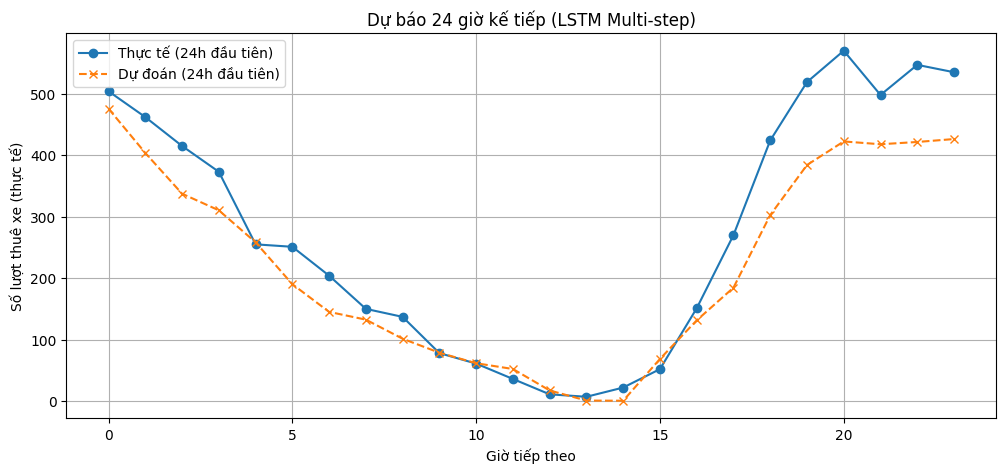

In [24]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Dự đoán
y_pred_scaled = model.predict(X_test)

# Giải chuẩn hóa (áp dụng cho toàn bộ ma trận)
scaler_y = MinMaxScaler()
scaler_y.fit(data[['cnt']])  # dùng scaler đã huấn luyện trên cột 'cnt'

# Inverse transform từng giá trị trong y_test và y_pred
y_test_real = scaler_y.inverse_transform(y_test)
y_pred_real = scaler_y.inverse_transform(y_pred_scaled)

# Đánh giá trung bình theo từng bước dự đoán
mse = mean_squared_error(y_test_real.flatten(), y_pred_real.flatten())
r2 = r2_score(y_test_real.flatten(), y_pred_real.flatten())

print(f"MSE (giá trị thật): {mse:.2f}")
print(f"R² (giá trị thật): {r2:.4f}")

# Vẽ biểu đồ minh họa 1 vài chuỗi 24h thực tế vs dự đoán
plt.figure(figsize=(12,5))
plt.plot(y_test_real[0], label="Thực tế (24h đầu tiên)", marker='o')
plt.plot(y_pred_real[0], label="Dự đoán (24h đầu tiên)", marker='x', linestyle='--')
plt.title("Dự báo 24 giờ kế tiếp (LSTM Multi-step)")
plt.xlabel("Giờ tiếp theo")
plt.ylabel("Số lượt thuê xe (thực tế)")
plt.legend()
plt.grid(True)
plt.show()


## 2.7 Thực hiện dự đoán số lượt thuê xe đạp trong 24 giờ tiếp theo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


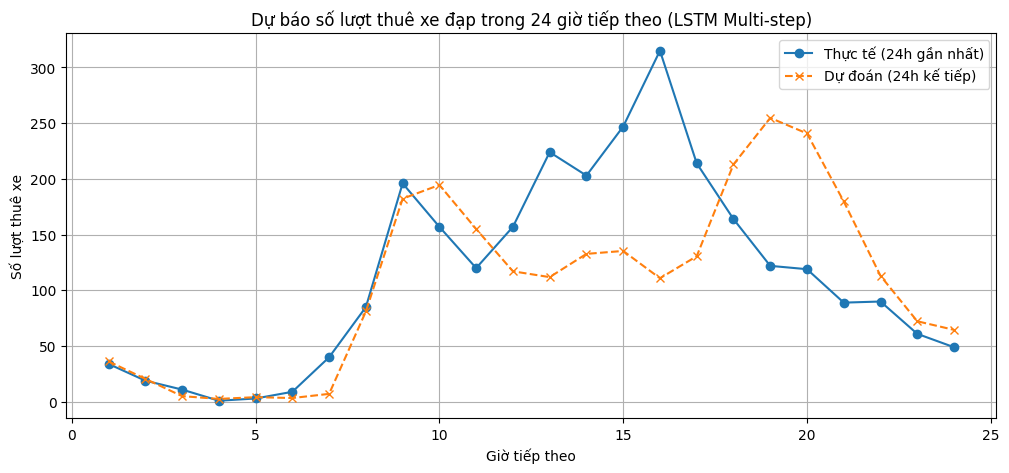

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Lấy chuỗi 24h gần nhất trong tập test
last_sequence = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

# Dự đoán 24 giờ kế tiếp chỉ trong 1 lần
predictions_scaled = model.predict(last_sequence)[0]

# Giải chuẩn hóa về giá trị thật
scaler_y = MinMaxScaler()
scaler_y.fit(data[['cnt']])
predicted_real_values = scaler_y.inverse_transform(
    predictions_scaled.reshape(-1, 1)
).flatten()

# So sánh với 24 giá trị thực gần nhất (nếu có)
real_last_24 = df['cnt'].iloc[-24:].values

# Vẽ biểu đồ
plt.figure(figsize=(12,5))
plt.plot(range(1,25), real_last_24, label="Thực tế (24h gần nhất)", marker='o')
plt.plot(range(1,25), predicted_real_values, label="Dự đoán (24h kế tiếp)", marker='x', linestyle='--')
plt.title("Dự báo số lượt thuê xe đạp trong 24 giờ tiếp theo (LSTM Multi-step)")
plt.xlabel("Giờ tiếp theo")
plt.ylabel("Số lượt thuê xe")
plt.legend()
plt.grid(True)
plt.show()


## 2.8 Nhận xét:
Mô hình LSTM mô phỏng xu hướng tổng thể tốt hơn RNN, đặc biệt ở giai đoạn đầu và giữa chu kỳ, tuy vẫn có độ lệch biên độ tại các đỉnh và đáy. Nhờ cơ chế ghi nhớ dài hạn, LSTM thể hiện độ ổn định và mượt hơn, phản ánh xu hướng dữ liệu thời gian hiệu quả hơn so với RNN.